In [1]:
from IPython.display import clear_output
from numpy import max, min

from aggr_utils import print_system_info
import tensorflow as tf
import imgaug.augmenters as iaa
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import os
import numpy as np
import matplotlib
from keras.api.layers import Input
from keras.api.models import Model
from keras.api.layers import Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import datetime

from keras import regularizers
from keras.src.applications.mobilenet_v3 import MobileNetV3Large, preprocess_input

from keras.api.callbacks import (
    Callback,
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
    EarlyStopping,
    ReduceLROnPlateau
)

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix
)
import math

In [2]:
print_system_info()
seed = 73
IMG_SIZE = 224
COLOR_CHANNELS = 3
FRAMES_PER_SECOND = 2

Operating System: Windows-10-10.0.26100-SP0
Python version: 3.11.9
Tensorflow version: 2.19.0


In [3]:
tf.random.set_seed(seed)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi


Sun May  4 08:31:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   29C    P8              8W /  160W |    1321MiB /   8188MiB |     39%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
PROJECT_DIR = '../datasets/violence'

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [5]:
def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    frame_rate = vidcap.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(frame_rate // FRAMES_PER_SECOND)
    count = 0

    ImageFrames = []
    while vidcap.isOpened():
        frame_id = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            if frame_id % frames_to_skip == 0:
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                image_aug = flip(image=image)
                image_aug = random_brightness(image=image_aug)
                image_aug = zoom(image=image_aug)
                image_aug = rotate(image=image_aug)

                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)

            count += 1
        else:
            break

    vidcap.release()

    return ImageFrames

In [6]:
video_data_dir = os.path.join(PROJECT_DIR, 'Real Life Violence Dataset')

print('Доступно \n{} видео с агрессией \n{} видео без агрессии'.format(
    len(os.listdir(video_data_dir + '/Violence')),
    len(os.listdir(video_data_dir + '/NonViolence'))))

X_original = []
y_original = []

# Выбор случайных 700 видео для решения проблем с памятью
# 350 с агрессией и 350 без
VIDEOS_PER_CLASS = 500
CLASSES = ["NonViolence", "Violence"]

for category in CLASSES:
    path = os.path.join(video_data_dir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:VIDEOS_PER_CLASS])):
        frames = video_to_frames(os.path.join(path, video))
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

Доступно 
1000 видео с агрессией 
1000 видео без агрессии


100%|██████████| 500/500 [01:04<00:00,  7.71it/s]


In [7]:
X_original = np.array(X_original).reshape(-1, IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
print(len(X_original))

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=seed)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]


def preprocess_input(x):
    x = x.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS) / 255.0
    # Модель ожидает на вход от -1.0 до 1.0
    return (x - 0.5) * 2.0


X_train_nn = preprocess_input(X_train)
X_test_nn = preprocess_input(X_test)

10919


## **Model Training**

In [8]:
clear_output()

In [9]:
matplotlib.use("Agg")
print(min(X_train_nn))
print(max(X_train_nn))

-1.0
1.0


In [ ]:
epochs = 50
kernel_regularizer = regularizers.l2(0.0001)


def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS))
    baseModel = MobileNetV3Large(
        pooling='avg',
        include_top=False,
        include_preprocessing=False,
        input_tensor=input_tensor,
        input_shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
    )

    print(input_tensor)
    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid", kernel_regularizer=kernel_regularizer)(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])

    return model


if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

In [11]:
PATIENCE = 3

START_LR = 0.00001
MIN_LR = 0.00001
MAX_LR = 0.00005

BATCH_SIZE = 4
RAMP_UP_EPOCHS = 5
SUSTAIN_EPOCHS = 0
EXP_DECAY = .8
EARLY_STOP_ACCURACY = 0.999

if TPU_INIT:
    MAX_LR *= tpu_strategy.num_replicas_in_sync
    BATCH_SIZE *= tpu_strategy.num_replicas_in_sync


def lr_fn(epoch):
    if epoch < RAMP_UP_EPOCHS:
        lr = (MAX_LR - START_LR) / RAMP_UP_EPOCHS * epoch + START_LR
    elif epoch < RAMP_UP_EPOCHS + SUSTAIN_EPOCHS:
        lr = MAX_LR
    else:
        decay_epoch = epoch - RAMP_UP_EPOCHS - SUSTAIN_EPOCHS
        lr = (MAX_LR - MIN_LR) * (EXP_DECAY ** decay_epoch) + MIN_LR
    return lr


class EarlyStopCallback(Callback):
    def __init__(self, target_acc=EARLY_STOP_ACCURACY):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        accuracy = logs.get('accuracy')

        if accuracy >= self.target_acc:
            print("\nДостигнут лимит остановки обучения!")
            self.model.stop_training = True

In [12]:
CHECKPOINT_FILEPATH = "ModelWeights_v3.weights.h5"


def build_callbacks(checkpoint_filepath=CHECKPOINT_FILEPATH, log_dir="logs/fit/"):
    log_dir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = []

    callbacks.append(
        EarlyStopCallback()
    )

    callbacks.append(
        LearningRateScheduler(
            lambda epoch: lr_fn(epoch),
            verbose=False
        )
    )

    callbacks.append(
        ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True
        )
    )

    if not TPU_INIT:
        callbacks.append(
            TensorBoard(
                log_dir=log_dir,
                write_graph=True,
                histogram_freq=1
            )
        )

    callbacks.append(
        EarlyStopping(
            patience=PATIENCE,
            monitor='val_loss',
            mode='min',
            restore_best_weights=True,
            verbose=1,
            min_delta=.00075
        )
    )

    callbacks.append(
        ReduceLROnPlateau(
            patience=2,
            mode='min'
        )
    )

    return callbacks


os.system('rm -rf ./logs/')
callbacks = build_callbacks()

In [13]:
def train_model(_model):
    print("Начало обучения головы модели")
    history = _model.fit(
        X_train_nn,
        y_train,
        validation_data=(X_test_nn, y_test),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    print(f'\nВосстановление лучших весов для MobileNetV3 из {CHECKPOINT_FILEPATH}')
    _model.load_weights(CHECKPOINT_FILEPATH)

    return history

In [14]:
history = train_model(model)

1909/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9623 - loss: 0.1205
Epoch 36: val_loss improved from 0.12726 to 0.12641, saving model to ModelWeights_v3.weights.h5
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9623 - loss: 0.1205 - val_accuracy: 0.9603 - val_loss: 0.1264 - learning_rate: 1.0050e-05
Epoch 37/50
1909/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9628 - loss: 0.1195
Epoch 37: val_loss improved from 0.12641 to 0.12559, saving model to ModelWeights_v3.weights.h5
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9628 - loss: 0.1195 - val_accuracy: 0.9612 - val_loss: 0.1256 - learning_rate: 1.0040e-05
Epoch 38/50
1909/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9634 - loss: 0.1186
Epoch 38: val_loss improved from 0.12559 to 0.12478, saving model to ModelWeights_v3.weights.h5
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step - accuracy: 0.9634 - loss: 0.1186 - val_accuracy: 0.9615 - val_loss: 0.1248 - learning_rate: 1.0032e-05
Epoch 3

In [22]:
%matplotlib inline

def print_graph(history, metric, best_epoch, save=True):
    plt.figure()

    plt.plot(history.history[metric], label='Train')
    plt.plot(history.history[f'val_{metric}'], label='Val')

    if best_epoch is not None:
        plt.axvline(best_epoch, linestyle='--', color='gray', alpha=0.6, label='Best Epoch')

    plt.title(f'{metric.capitalize()} по эпохам')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

    if save:
        plot = '{}.png'.format(metric)
        plt.savefig(plot)
    plt.show()


def model_summary(_model, _history, _x_test, _y_test):
    print('---' * 30)
    test_loss, test_accuracy = _model.evaluate(_x_test, _y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")

    # Определим лучшую эпоху по минимальному val_loss
    if _history:
        val_losses = _history.history['val_loss']
        best_epoch = int(np.argmin(val_losses))

        print(f'Лучшая эпоха: {best_epoch}')
        print(f"Train Acc: {_history.history['accuracy'][best_epoch]:.4f} | "
              f"Train Loss: {_history.history['loss'][best_epoch]:.4f}")

        print_graph(_history, 'accuracy', best_epoch)
        print_graph(_history, 'loss', best_epoch)
        print('---' * 30)

------------------------------------------------------------------------------------------
Test Accuracy: 0.9643 | Test Loss: 0.1165
Лучшая эпоха: 49
Train Acc: 0.9669 | Train Loss: 0.1100


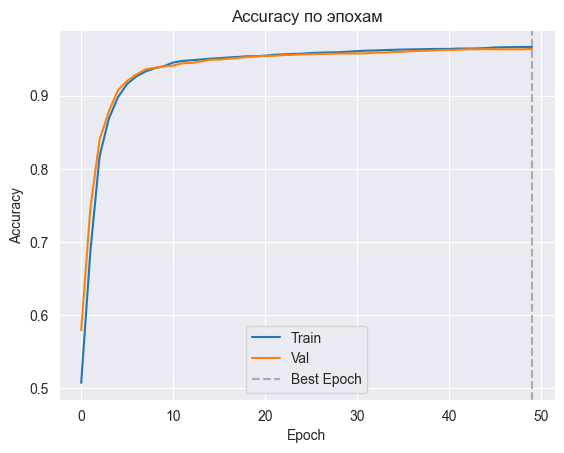

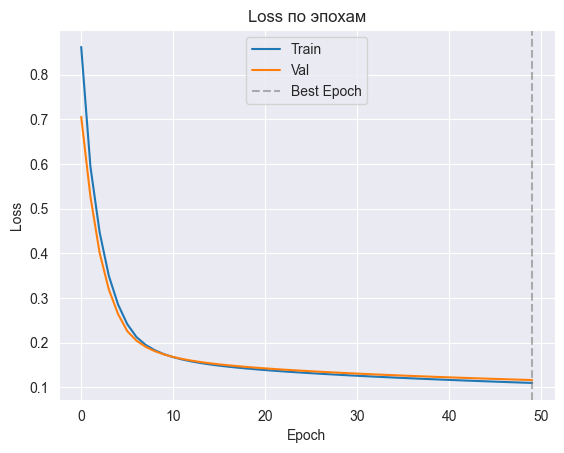

------------------------------------------------------------------------------------------


In [23]:
model_summary(model, history, X_test_nn, y_test)

## **Evaluation on test set**

> Correct Predictions: 3159
> Wrong Predictions: 117


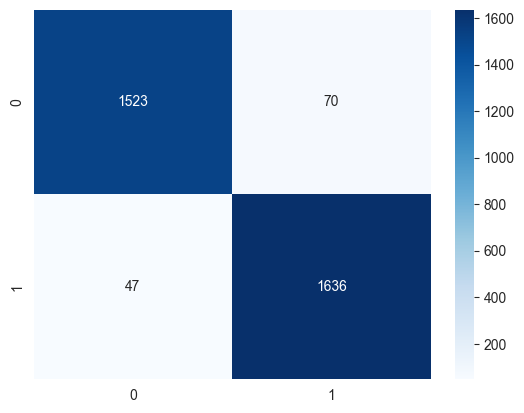

              precision    recall  f1-score   support

 NonViolence       0.97      0.96      0.96      1593
    Violence       0.96      0.97      0.97      1683

    accuracy                           0.96      3276
   macro avg       0.96      0.96      0.96      3276
weighted avg       0.96      0.96      0.96      3276



In [18]:
# evaluate the network
print("Проверка модели...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.uint64((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.uint((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds,
                                    target_names=["NonViolence", "Violence"]))


=== Проверка модели ===
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step
> Correct Predictions: 3159
> Wrong Predictions: 117

Confusion Matrix:


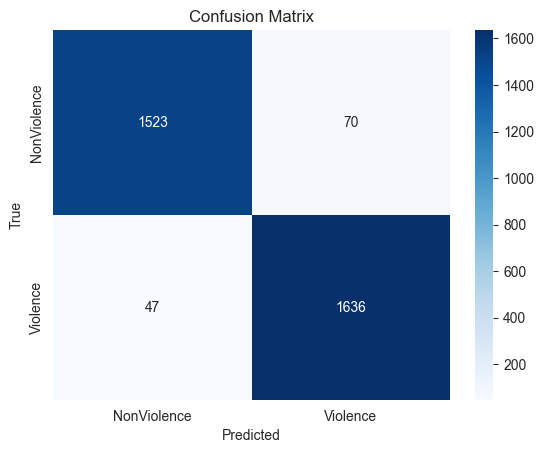


Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.97      0.96      0.96      1593
    Violence       0.96      0.97      0.97      1683

    accuracy                           0.96      3276
   macro avg       0.96      0.96      0.96      3276
weighted avg       0.96      0.96      0.96      3276

ROC-AUC: 0.9932


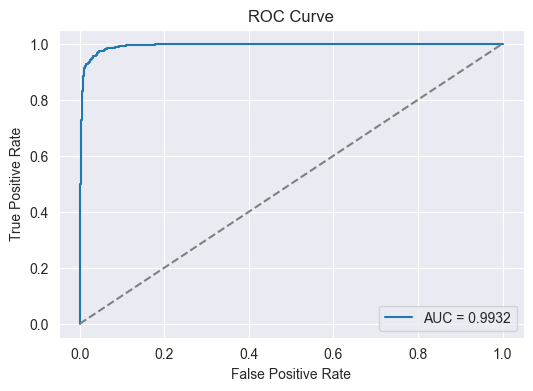

In [25]:
def evaluate_model(_model, _x_test, _y_test, threshold=0.5):
    print("\n=== Проверка модели ===")
    _predictions = _model.predict(_x_test, batch_size=64, verbose=1).flatten()
    predictions_binary = (_predictions > threshold).astype(int)

    # Confusion matrix
    cm = metrics.confusion_matrix(_y_test, predictions_binary)
    correct = np.sum(np.diag(cm))
    total = np.sum(cm)

    print(f"> Correct Predictions: {correct}")
    print(f"> Wrong Predictions: {total - correct}")
    print("\nConfusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NonViolence", "Violence"],
                yticklabels=["NonViolence", "Violence"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(metrics.classification_report(_y_test, predictions_binary,
                                        target_names=["NonViolence", "Violence"]))

    auc = metrics.roc_auc_score(_y_test, _predictions)
    print(f"ROC-AUC: {auc:.4f}")

    # ROC Curve
    fpr, tpr, _ = metrics.roc_curve(_y_test, _predictions)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_model(model, X_test_nn, y_test)

In [21]:
args_model = "./mobilenet_v3_model.keras"
model.save(args_model)